In [2]:
# In this I have imported torch and its Dataset. Dataset stores the data and labels and DataLoader which is imported later makes an iterable
# around Dataset to use it later ig.
!pip install --upgrade sympy
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import random

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 56.1 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.1
    Uninstalling sympy-1.13.1:
      Successfully uninstalled sympy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cud

In [3]:
train_data = datasets.CIFAR10(
    root="data",  # means stores in root directory
    train=True, # means this loads training data as it is true. if false then it should be testing data
    download=True,  #download in directory if not already present there
    transform=ToTensor() #converts the PIL images to tensors. See pillow on google.
)

test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 170M/170M [00:02<00:00, 85.1MB/s]


In [4]:
class NoisyCIFAR10(Dataset):
    def __init__(self, dataset, noise_rate=0.0):
        self.data = []
        for img, label in dataset:
            if random.random() < noise_rate:
                new_label = (label + random.randint(1, 9)) % 10
                self.data.append((img, new_label))
            else:
                self.data.append((img, label))

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)

def get_noisy_cifar10(noise_rate):
    noisy_train_data = NoisyCIFAR10(train_data, noise_rate)
    return noisy_train_data, test_data


In [5]:
# part A ends here of core ml project.

In [6]:
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# apparently this code is required for using GPU which makes things run faster than normal CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [7]:
# now we make theCross-entropy loss function
def cross_entropy(y_true, y_pred):
  epslon = 1e-12
  ans = -1 * np.sum(y_true * np.log(y_pred + epslon))/len(y_true)
  # we added the epsilon so that incase y_pred=0, log doesn't become minus inf
  return ans

### I later came to know we don't need this function, there's inbuilt function called nn.crossentropy

In [9]:
# normalized cross entropy is basically the loss function of cross entropy at a particualr value divided by the sum of all such possible functions.
import torch.nn as nn
class NormalizedCrossEntropy(nn.Module):
    def forward(self, logits, targets):
        probs = F.softmax(logits, dim=1)
        log_probs = torch.log(probs + 1e-9)
        loss = -log_probs[range(len(targets)), targets]
        denom = -log_probs.mean(dim=1)
        return (loss / denom).mean()


In [10]:

# Reverse cross entropy is basically CE but probability variables are put in other way.
class ReverseCrossEntropy(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, logits, targets):
        probs = F.softmax(logits, dim=1)
        label_onehot = F.one_hot(targets, num_classes=logits.size(1)).float()
        clipped = torch.clamp(label_onehot, min=1e-9)
        log_label = torch.log(clipped)
        loss = -torch.sum(probs * log_label, dim=1)
        return loss.mean()


In [11]:
# according to the given research paper APL is basically a combination of an active and a passive loss function in some ratio(we have taken 1:1 for ease ig)
# so for this project APL implementation is basically: NCE + RCE
# but when I implemented this in the end I got different results. GPT recommended to change the values of alpha and beta and in the final call.
# so do go to the bottom and u'll see that a and b are not 1,1 but 10,0.1.
class APL_NCE_RCE(nn.Module):
    def __init__(self, alpha=1.0, beta=1.0):
        super().__init__()
        self.nce = NormalizedCrossEntropy()
        self.rce = ReverseCrossEntropy()
        self.alpha = alpha
        self.beta = beta

    def forward(self, logits, targets):
        return self.alpha * self.nce(logits, targets) + self.beta * self.rce(logits, targets)


In [12]:
# the train function is where I faced a lot of difficutlies cuz I wasn't aware of some terms but with help of several LLMs I was able to find what I needed and got this.

def train(model, train_loader, optimizer, criterion, device, num_epochs=30):
    model.to(device)
    model.train()

    for epoch in range(num_epochs):
        total_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (outputs.argmax(dim=1) == labels).sum().item()
            total += labels.size(0)

        acc = 100 * correct / total
        print(f"[{epoch+1}/{num_epochs}] Loss: {total_loss:.4f}, Acc: {acc:.2f}%")


In [13]:
def evaluate(model, test_loader, device):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            correct += (outputs.argmax(dim=1) == labels).sum().item()
            total += labels.size(0)

    return 100 * correct / total


In [14]:

def plot_results(results, noise_levels):
    plt.figure(figsize=(8, 6))
    for loss_name, accuracies in results.items():
        plt.plot(noise_levels, accuracies, label=loss_name)

    plt.xlabel("Noise Rate (η)")
    plt.ylabel("Test Accuracy")
    plt.title("Accuracy vs Noise Rate on CIFAR-10")
    plt.grid(True)
    plt.legend()
    plt.show()


In [21]:

noise_levels = [0.2, 0.4, 0.6, 0.8]
results = {'CE': [], 'NCE': [], 'APL': []}
results_2 = {'CE': [], 'NCE': []}

for noise_rate in noise_levels:
    print(f"\n=== Noise rate: {noise_rate} ===")
    train_dataset, test_dataset = get_noisy_cifar10(noise_rate)
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

    for loss_name, loss_fn in [
        ("CE", nn.CrossEntropyLoss()),
        ("NCE", NormalizedCrossEntropy()),
        ("APL", APL_NCE_RCE(alpha=10.0, beta=0.1))
    ]:
        print(f"\nTraining with: {loss_name}")
        # resnet 18 CNN was used.
        model = models.resnet18(pretrained=False, num_classes=10)
        # lr at first I had kept 0.1 as recommended by Karan bhaiya but LLMs said that for a good report keep lower as anyways I was using GPU on colab.
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

        try:
            train(model, train_loader, optimizer, loss_fn, device, num_epochs=10)
            acc = evaluate(model, test_loader, device)
            print(f"Test Acc for {loss_name} @ η={noise_rate}: {acc:.2f}%")
            results[loss_name].append(acc)  # Store results for all loss functions
            # Store results for CE and NCE in results_2 as well
            if loss_name in results_2:
                results_2[loss_name].append(acc)
        except Exception as e:
            print(f"Error with {loss_name} at η={noise_rate}: {e}")
            results[loss_name].append(0)
            # Append 0 to results_2 for CE and NCE in case of errors
            if loss_name in results_2:
                results_2[loss_name].append(0)




=== Noise rate: 0.2 ===

Training with: CE


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


[1/10] Loss: 769.9835, Acc: 33.14%
[2/10] Loss: 679.8793, Acc: 43.90%
[3/10] Loss: 634.8499, Acc: 49.28%
[4/10] Loss: 595.5705, Acc: 53.29%
[5/10] Loss: 561.6779, Acc: 56.55%
[6/10] Loss: 528.0724, Acc: 59.66%
[7/10] Loss: 494.8986, Acc: 62.23%
[8/10] Loss: 467.3270, Acc: 64.30%
[9/10] Loss: 432.7576, Acc: 66.80%
[10/10] Loss: 398.2555, Acc: 69.37%
Test Acc for CE @ η=0.2: 58.03%

Training with: NCE
[1/10] Loss: 193.6392, Acc: 32.65%
[2/10] Loss: 151.7287, Acc: 41.02%
[3/10] Loss: 138.0549, Acc: 44.86%
[4/10] Loss: 127.3814, Acc: 47.93%
[5/10] Loss: 118.0399, Acc: 50.28%
[6/10] Loss: 107.3668, Acc: 52.77%
[7/10] Loss: 97.8351, Acc: 55.05%
[8/10] Loss: 87.9218, Acc: 57.48%
[9/10] Loss: 78.7996, Acc: 59.75%
[10/10] Loss: 69.5181, Acc: 61.78%
Test Acc for NCE @ η=0.2: 51.24%

Training with: APL
[1/10] Loss: 2431.1511, Acc: 32.35%
[2/10] Loss: 2022.0247, Acc: 41.65%
[3/10] Loss: 1814.5363, Acc: 47.69%
[4/10] Loss: 1680.4947, Acc: 51.45%
[5/10] Loss: 1571.6676, Acc: 54.46%
[6/10] Loss: 1462

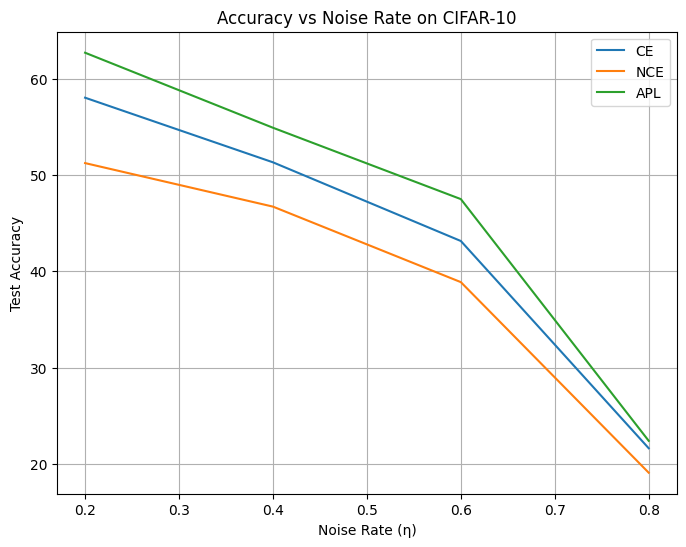


Final Results:
{'CE': [58.03, 51.32, 43.15, 21.63], 'NCE': [51.24, 46.72, 38.88, 19.09], 'APL': [62.7, 54.91, 47.5, 22.4]}


In [22]:
plot_results(results, noise_levels)  # Plot for all loss functionsr task 2 plot:")
print("\nFinal Results:")
print(results)

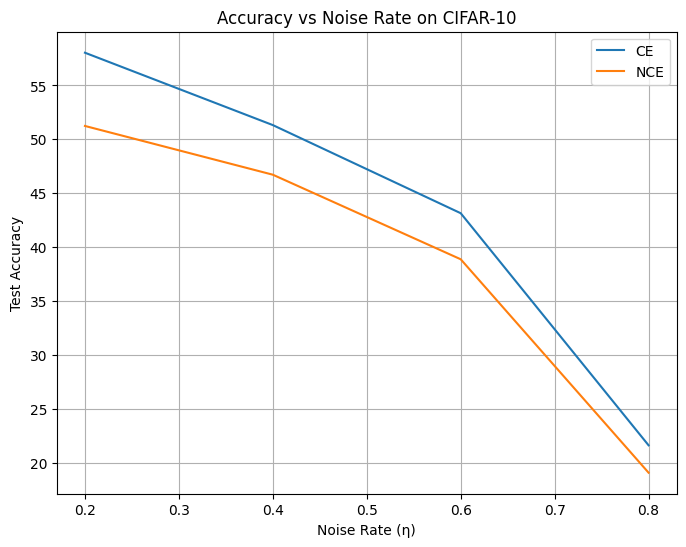


Results for task 2
{'CE': [58.03, 51.32, 43.15, 21.63], 'NCE': [51.24, 46.72, 38.88, 19.09]}


In [23]:
plot_results(results_2, noise_levels)  # Plot for CE and NCE only
print("\nResults for task 2")
print(results_2)